In [1]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-11"

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Criando a SparkSession
spark = SparkSession.builder \
    .appName("Olist Sales Analysis") \
    .getOrCreate()

# Caminho base dos arquivos
base_path = "../data/raw/"

# Carregando os principais datasets
orders = spark.read.csv(base_path + "olist_orders_dataset.csv", header=True, inferSchema=True)
order_items = spark.read.csv(base_path + "olist_order_items_dataset.csv", header=True, inferSchema=True)
customers = spark.read.csv(base_path + "olist_customers_dataset.csv", header=True, inferSchema=True)
products = spark.read.csv(base_path + "olist_products_dataset.csv", header=True, inferSchema=True)
sellers = spark.read.csv(base_path + "olist_sellers_dataset.csv", header=True, inferSchema=True)
reviews = spark.read.csv(base_path + "olist_order_reviews_dataset.csv", header=True, inferSchema=True)
payments = spark.read.csv(base_path + "olist_order_payments_dataset.csv", header=True, inferSchema=True)

# Visualizar os schemas
orders.printSchema()
order_items.printSchema()
payments.printSchema()


root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: double (nullable = true)



In [2]:
# Quantos pedidos foram feitos?
orders.count()

99441

In [3]:
#Quais os status mais comuns?
orders.groupBy("order_status").count().show()

+------------+-----+
|order_status|count|
+------------+-----+
|     shipped| 1107|
|    canceled|  625|
|    invoiced|  314|
|     created|    5|
|   delivered|96478|
| unavailable|  609|
|  processing|  301|
|    approved|    2|
+------------+-----+



In [4]:
from pyspark.sql.functions import sum

#Receita total
total_receita = order_items.agg(sum("price")).collect()[0][0]

# Exibir de forma amigável
print(f"Receita total: R$ {total_receita:,.2f}")

Receita total: R$ 13,591,643.70


In [5]:
#Médias de preço por categoria
from pyspark.sql.functions import avg

products.join(order_items, "product_id") \
    .groupBy("product_category_name") \
    .agg(avg("price").alias("avg_price")) \
    .orderBy("avg_price", ascending=False) \
    .show(10, truncate=False)

+---------------------------------------------+------------------+
|product_category_name                        |avg_price         |
+---------------------------------------------+------------------+
|pcs                                          |1098.340541871921 |
|portateis_casa_forno_e_cafe                  |624.2856578947367 |
|eletrodomesticos_2                           |476.12495798319344|
|agro_industria_e_comercio                    |342.1248584905661 |
|instrumentos_musicais                        |281.61600000000044|
|eletroportateis                              |280.77846833578803|
|portateis_cozinha_e_preparadores_de_alimentos|264.5686666666667 |
|telefonia_fixa                               |225.69318181818207|
|construcao_ferramentas_seguranca             |208.99237113402052|
|relogios_presentes                           |201.13598397596448|
+---------------------------------------------+------------------+
only showing top 10 rows



In [6]:
# Top 10 categorias com mais reiceitas:

# Juntando itens de pedido com produtos para obter categorias
itens_com_produtos = order_items.join(products, "product_id")

# Receita por categoria
receita_por_categoria = itens_com_produtos.groupBy("product_category_name") \
    .agg({"price": "sum"}) \
    .orderBy("sum(price)", ascending=False)

receita_por_categoria.show(10, truncate=False)


+----------------------+------------------+
|product_category_name |sum(price)        |
+----------------------+------------------+
|beleza_saude          |1258681.3400000052|
|relogios_presentes    |1205005.6800000032|
|cama_mesa_banho       |1036988.680000001 |
|esporte_lazer         |988048.9699999947 |
|informatica_acessorios|911954.3199999924 |
|moveis_decoracao      |729762.489999984  |
|cool_stuff            |635290.849999994  |
|utilidades_domesticas |632248.65999999   |
|automotivo            |592720.1099999945 |
|ferramentas_jardim    |485256.45999999484|
+----------------------+------------------+
only showing top 10 rows



In [7]:
#Vedores com maior faturamentos:
vendedor_receita = order_items.groupBy("seller_id") \
    .agg(sum("price").alias("total_revenue")) \
    .orderBy(col("total_revenue").desc())

vendedor_receita.show(10)           

+--------------------+------------------+
|           seller_id|     total_revenue|
+--------------------+------------------+
|4869f7a5dfa277a7d...|229472.63000000027|
|53243585a1d6dc264...|222776.04999999993|
|4a3ca9315b744ce9f...|200472.92000000135|
|fa1c13f2614d7b5c4...|194042.03000000046|
|7c67e1448b00f6e96...|187923.88999999987|
|7e93a43ef30c4f03f...| 176431.8699999999|
|da8622b14eb17ae28...|160236.57000000132|
|7a67c85e85bb2ce85...|         141745.53|
|1025f0e2d44d7041d...|138968.55000000013|
|955fee9216a65b617...| 135171.7000000003|
+--------------------+------------------+
only showing top 10 rows



In [8]:
from pyspark.sql.functions import sum as _sum

ticket_medio = order_items.groupBy("order_id") \
    .agg(_sum("price").alias("order_value"))

media_ticket = ticket_medio.agg({"order_value": "avg"}).collect()[0][0]
print(f"Ticket médio por pedido: R$ {media_ticket:,.2f}")


Ticket médio por pedido: R$ 137.75


In [9]:
#Tem muitos pedidos com atraso?

from pyspark.sql.functions import col

# Calculando se houve atraso
orders_com_atraso = orders.withColumn(
    "atrasado", col("order_delivered_customer_date") > col("order_estimated_delivery_date")
)

percentual_atraso = orders_com_atraso.filter(col("atrasado") == True).count() / orders.count() * 100
print(f"Percentual de pedidos com atraso: {percentual_atraso:.2f}%")


Percentual de pedidos com atraso: 7.87%


In [10]:
# Como está a satisfação (reviews)?
media_review = reviews.agg({"review_score": "avg"}).collect()[0][0]
print(f"Avaliação média: {media_review:.2f}")


Avaliação média: 4.09


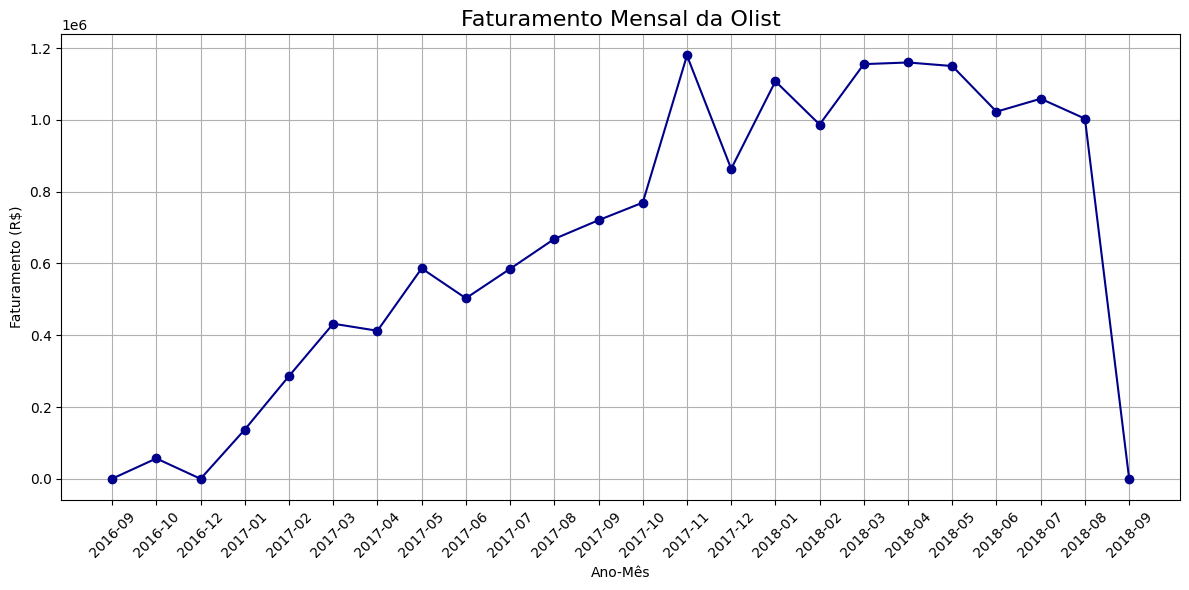

In [11]:
from pyspark.sql.functions import year, month, sum as spark_sum, to_date, col, date_format
import matplotlib.pyplot as plt

# 1. Convertendo a data do pedido
orders_with_date = orders.withColumn("order_purchase_timestamp", to_date("order_purchase_timestamp"))

# 2. Juntando com order_items para ter os preços
df_joined = orders_with_date.join(order_items, on="order_id", how="inner")

# 3. Adicionando colunas de ano/mês e somando valores
df_grouped = df_joined.withColumn("ano_mes", date_format("order_purchase_timestamp", "yyyy-MM")) \
    .groupBy("ano_mes") \
    .agg(
        spark_sum(col("price") + col("freight_value")).alias("faturamento_mensal")
    ) \
    .orderBy("ano_mes")

# 4. Coletando os dados para o gráfico
dados_plot = df_grouped.toPandas()

# 5. Plotando
plt.figure(figsize=(12,6))
plt.plot(dados_plot["ano_mes"], dados_plot["faturamento_mensal"], marker='o', color='darkblue')
plt.title("Faturamento Mensal da Olist", fontsize=16)
plt.xlabel("Ano-Mês")
plt.ylabel("Faturamento (R$)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
